# Importing all the Required packages that we'll use first

In [111]:
import random
import pickle
import time
import pathlib

import pandas as pd
import numpy as np
import rasterio as rio
import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import matplotlib.font_manager
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.neural_network import MLPClassifier # Maybe we'll use this instead
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import ShuffleSplit

from yellowbrick.regressor import PredictionError
from sklearn.metrics import r2_score
# from sklearn.metrics import precision_score, recall_score, make_scorer

# import cartopy

coreLimit = int(336*(3/4)) # Parallel Processing # 336 Total Cores Available
# Predicting on biomass_mg

## Creating a Data Handling Class for ease of passing data around. 

In [112]:
class Data():
    def __init__(self, X=None, Y=None):
        if X != None:
            self.__x = X
        else:
            self.__x = 0
        if Y != None:
            self.__y = Y
        else:
            self.__y = 0

    def __del__(self):
        del self.__x, self.__y

    def set_x(self, X):
        self.__x = X

    def set_y(self, Y):
        self.__y = Y
        
    def get_x(self):
        return self.__x

    def get_y(self):
        return self.__y
# end Data

## Reading Data into Memory

In [113]:
USFS_forest_file = 'data/csv_files/USFS_forest_clustered_great.csv'
USFS_forest = pd.read_csv(USFS_forest_file)

# Removing invalid data (i.e., -9999.0)
count = 0
for i in USFS_forest:
    USFS_forest = USFS_forest[USFS_forest[i] != -9999.0] # Recreating dataset without invalid rows
    if i == 'Age2018' or i == 'biomass_mg':
        USFS_forest = USFS_forest[USFS_forest[i] != 0]
USFS_forest['Carbon2018'] = USFS_forest['Carbon2018']*11.11
USFS_forest = USFS_forest.rename(columns={'Carbon2018': 'Carbon (mg/ha)'})
print(USFS_forest.describe()) # Post-Removal
# print(np.unique(USFS_forest['labels'].values))

         Unnamed: 0             id   NDVI_Jun13   NDMI_Jun13    PRISM_ppt  \
count   8974.000000    8974.000000  8974.000000  8974.000000  8974.000000   
mean    5266.443503  150377.090372  3718.534999  2573.091246  1844.852920   
std     3051.264745   86870.722503  1008.902601  1038.802994   799.249613   
min       18.000000      37.000000   526.493000 -1539.970000   264.963000   
25%     2575.250000   76159.500000  3010.157500  2120.062500  1323.510000   
50%     5262.500000  150147.000000  3767.335000  2821.760000  1818.985000   
75%     7813.750000  225756.000000  4486.300000  3302.072500  2340.010000   
max    10632.000000  299930.000000  6254.720000  4616.590000  5057.150000   

        PRISM_tave   biomass_mg  Carbon (mg/ha)    Stock2018      Age2018  \
count  8974.000000  8974.000000     8974.000000  8974.000000  8974.000000   
mean      9.865800   207.343214      582.718068    56.094156    64.437761   
std       1.604252    80.446479      377.326760    14.186152    38.423668  

### Splitting the Data via labels

In [114]:
USFS_forest_0 = [] # for label 0
USFS_forest_1 = [] # for label 1
USFS_forest_2 = [] # for label -1

for i, row in USFS_forest.iterrows():
    # print(row['id'], row['labels'])
    if row['labels'] == -1:
        USFS_forest_2.append(row)
    elif row['labels'] == 0:
        USFS_forest_0.append(row)
    elif row['labels'] == 1:
        USFS_forest_1.append(row)
    else:
        print('Something went wrong with: ', i)

USFS_forest_0 = pd.DataFrame(USFS_forest_0)
USFS_forest_1 = pd.DataFrame(USFS_forest_1)
USFS_forest_2 = pd.DataFrame(USFS_forest_2)
# USFS_forest_0.describe()
# USFS_forest_1.describe()
USFS_forest_2.describe()

,Unnamed: 0,id,NDVI_Jun13,NDMI_Jun13,PRISM_ppt,PRISM_tave,biomass_mg,Carbon (mg/ha),Stock2018,Age2018,Height2018,POINT_X,POINT_Y,labels
count,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.000000,3874.0
mean,4361.939597,149073.606866,3534.363099,2517.351884,1841.526715,9.865572,217.178412,797.627019,60.902222,91.391029,80.030674,-122.586391,44.482266,-1.0
std,3176.035235,86675.786871,911.726796,946.152807,823.261229,1.833672,84.024741,448.100201,14.978286,41.940070,25.537612,1.662169,2.645306,0.0
min,18.000000,107.000000,526.493000,-1452.660000,264.963000,4.600000,8.966810,0.203331,0.273811,0.000396,0.256902,-124.680069,38.809528,-1.0
25%,1428.250000,74715.250000,2922.265000,2060.090000,1284.007500,8.580000,163.644000,458.973315,53.618650,65.511250,65.839725,-123.726469,42.381306,-1.0
50%,3791.000000,147897.000000,3562.675000,2719.525000,1757.130000,9.980000,212.962000,835.831574,65.778750,89.490200,81.411000,-123.140333,45.081584,-1.0
75%,6958.750000,225170.250000,4224.510000,3174.770000,2360.040000,11.289900,262.279000,1059.669824,71.083175,113.470750,96.842225,-122.036022,46.528800,-1.0
max,10632.000000,299881.000000,5971.250000,4438.730000,5057.150000,14.620000,798.046000,2458.273704,94.819600,290.187000,153.434000,-117.086123,48.995166,-1.0


## Splitting the Data

In [115]:
training_split = 0.7
x_train, x_test , y_train, y_test= train_test_split(
    USFS_forest_0[[
        'NDVI_Jun13', 
        'NDMI_Jun13', 
        'PRISM_ppt', 
        'PRISM_tave', 
        # 'Carbon2018', # Possible Y # Uses Mg C per 30x30 Pixel (Conversion factor: 11.11 for Mg/ha)
        # 'Stock2018',  # Possible Y
        'Age2018', 
        # 'Height2018', # Possible Y
    ]], 
    USFS_forest_0['Carbon (mg/ha)'],
    train_size=training_split,
    shuffle=True, # Default: True
)
model_data_0 = Data() # A container for our data
model_data_0.set_x([x_train, x_test])
model_data_0.set_y([y_train, y_test])

# model_data_0.set_x([USFS_forest_0[['NDVI_Jun13', 'NDMI_Jun13', 'PRISM_ppt', 'PRISM_tave', 'Age2018',]], USFS_forest_0[['NDVI_Jun13', 'NDMI_Jun13', 'PRISM_ppt', 'PRISM_tave', 'Age2018',]]])
# model_data_0.set_y([USFS_forest_0[['Carbon (mg/ha)']], USFS_forest_0[['Carbon (mg/ha)']]])

x_train, x_test , y_train, y_test= train_test_split(
    USFS_forest_1[[
        'NDVI_Jun13', 
        'NDMI_Jun13', 
        'PRISM_ppt', 
        'PRISM_tave', 
        # 'Carbon2018', # Possible Y # Uses Mg C per 30x30 Pixel (Conversion factor: 11.11 for Mg/ha)
        # 'Stock2018',  # Possible Y
        'Age2018', 
        # 'Height2018', # Possible Y
    ]], 
    USFS_forest_1['Carbon (mg/ha)'],
    train_size=training_split,
    shuffle=True, # Default: True
)
model_data_1 = Data() # A container for our data
model_data_1.set_x([x_train, x_test])
model_data_1.set_y([y_train, y_test])

# model_data_1.set_x([USFS_forest_1[['NDVI_Jun13', 'NDMI_Jun13', 'PRISM_ppt', 'PRISM_tave', 'Age2018',]], USFS_forest_1[['NDVI_Jun13', 'NDMI_Jun13', 'PRISM_ppt', 'PRISM_tave', 'Age2018',]]])
# model_data_1.set_y([USFS_forest_1[['Carbon (mg/ha)']], USFS_forest_1[['Carbon (mg/ha)']]])

x_train, x_test , y_train, y_test= train_test_split(
    USFS_forest_2[[
        'NDVI_Jun13', 
        'NDMI_Jun13', 
        'PRISM_ppt', 
        'PRISM_tave', 
        # 'Carbon2018', # Possible Y # Uses Mg C per 30x30 Pixel (Conversion factor: 11.11 for Mg/ha)
        # 'Stock2018',  # Possible Y
        'Age2018', 
        # 'Height2018', # Possible Y
    ]], 
    USFS_forest_2['Carbon (mg/ha)'],
    train_size=training_split,
    shuffle=True, # Default: True
)
model_data_2 = Data() # A container for our data
model_data_2.set_x([x_train, x_test])
model_data_2.set_y([y_train, y_test])

# model_data_2.set_x([USFS_forest_2[['NDVI_Jun13', 'NDMI_Jun13', 'PRISM_ppt', 'PRISM_tave', 'Age2018',]], USFS_forest_2[['NDVI_Jun13', 'NDMI_Jun13', 'PRISM_ppt', 'PRISM_tave', 'Age2018',]]])
# model_data_2.set_y([USFS_forest_2[['Carbon (mg/ha)']], USFS_forest_2[['Carbon (mg/ha)']]])

### Showing current data

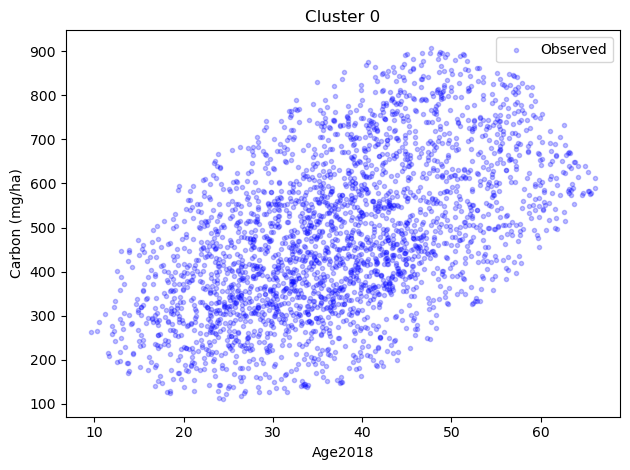

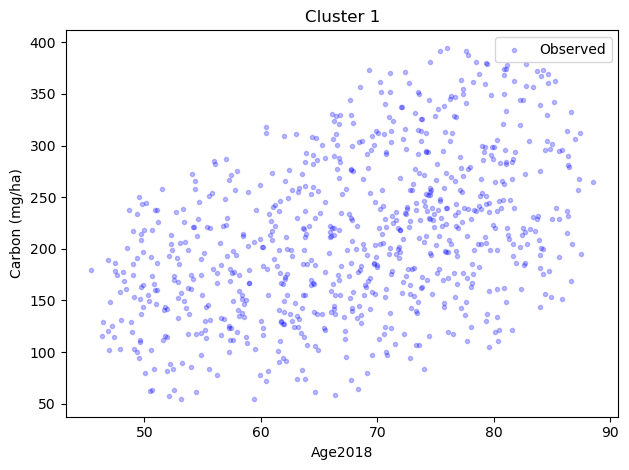

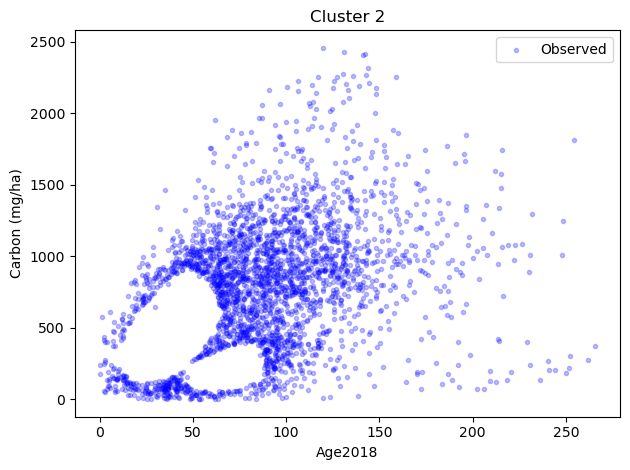

In [116]:
plot1 = plt.scatter(model_data_0.get_x()[0]['Age2018'], model_data_0.get_y()[0], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
# plot2 = plt.scatter(model_data_0.get_x()[1][v], pred_0, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel(v)
plt.legend(handles=[plot1], loc='best',)
plt.title('Cluster 0')
plt.tight_layout()
plt.show()

plot1 = plt.scatter(model_data_1.get_x()[0]['Age2018'], model_data_1.get_y()[0], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
# plot2 = plt.scatter(model_data_1.get_x()[1][v], pred_1, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel(v)
plt.legend(handles=[plot1], loc='best',)
plt.title('Cluster 1')
plt.tight_layout()
plt.show()

plot1 = plt.scatter(model_data_2.get_x()[0]['Age2018'], model_data_2.get_y()[0], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
# plot2 = plt.scatter(model_data_2.get_x()[1][v], pred_2, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel(v)
plt.legend(handles=[plot1], loc='best',)
plt.title('Cluster 2')
plt.tight_layout()
plt.show()

## Creating a new Model

In [117]:
pipe = Pipeline([
    ("scale", QuantileTransformer()), # Try without
    ("model", RandomForestRegressor()),
])  

model_0 = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'scale__n_quantiles':[i for i in range (10, int(len(USFS_forest_0)/2))], 
        # 'scale__random_state': [i for i in range(1, 1000)],
        'model__n_estimators': [i for i in range(100, 1000)], 
        'model__max_depth': [i for i in range(1, 2000)],
        # 'model__random_state': [i for i in range (1, 1000)],
        'model__max_features':['log2', 'sqrt',]+[i for i in range(1, 1000)],
        'model__min_samples_leaf':[i for i in range (1, 1000)],
        'model__min_samples_split':[i for i in range (2, 1000)],
        # 'verbose':[True],
    },
    refit=True,
    cv=10, # Cross Validations
    n_jobs=coreLimit, #252, # Parallel Processing # 336 Total Cores Available
    verbose=1,
    n_iter=1000, # Number of Iterations (Default: 10)
)
# model_0
model_1 = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'scale__n_quantiles':[i for i in range (10, int(len(USFS_forest_1)/2))], 
        # 'scale__random_state': [i for i in range(1, 1000)],
        'model__n_estimators': [i for i in range(100, 1000)], 
        'model__max_depth': [i for i in range(1, 2000)],
        # 'model__random_state': [i for i in range (1, 1000)],
        'model__max_features':['log2', 'sqrt',]+[i for i in range(1, 1000)],
        'model__min_samples_leaf':[i for i in range (1, 1000)],
        'model__min_samples_split':[i for i in range (2, 1000)],
        # 'verbose':[True],
    },
    refit=True,
    cv=10, # Cross Validations
    n_jobs=coreLimit, #252, # Parallel Processing # 336 Total Cores Available
    verbose=1,
    n_iter=1000, # Number of Iterations (Default: 10)
)
# model_0
model_2 = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'scale__n_quantiles':[i for i in range (10, int(len(USFS_forest_2)/2))], 
        # 'scale__random_state': [i for i in range(1, 1000)],
        'model__n_estimators': [i for i in range(100, 1000)], 
        'model__max_depth': [i for i in range(1, 2000)],
        # 'model__random_state': [i for i in range (1, 1000)],
        'model__max_features':['log2', 'sqrt',]+[i for i in range(1, 1000)],
        'model__min_samples_leaf':[i for i in range (1, 1000)],
        'model__min_samples_split':[i for i in range (2, 1000)],
        # 'verbose':[True],
    },
    refit=True,
    cv=10, # Cross Validations
    n_jobs=coreLimit, #252, # Parallel Processing # 336 Total Cores Available
    verbose=1,
    n_iter=1000, # Number of Iterations (Default: 10)
)
model_0
model_1
model_2
# print(model_2.get_params())

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scale', QuantileTransformer()),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_iter=1000, n_jobs=252,
                   param_distributions={'model__max_depth': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'model__max_features': ['log2', 'sqrt',
                                                                1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                11, 12, 13, 14,
                                                                15, 16, 17, 18...
                                                                     6, 7, 8, 9,
                                                                     10, 11, 12,
                                                                     13, 14, 15,
                                                                     16, 17, 18,
                                                                     19, 20, 21,
                                                                     22, 23, 24,
                                                                     25, 26, 27,
                                                                     28, 29, 30,
                                                                     31, ...],
                                        'model__n_estimators': [100, 101, 102,
                                                                103, 104, 105,
                                                                106, 107, 108,
                                                                109, 110, 111,
                                                                112, 113, 114,
                                                                115, 116, 117,
                                                                118, 119, 120,
                                                                121, 122, 123,
                                                                124, 125, 126,
                                                                127, 128, 129, ...],
                                        'scale__n_quantiles': [10, 11, 12, 13,
                                                               14, 15, 16, 17,
                                                               18, 19, 20, 21,
                                                               22, 23, 24, 25,
                                                               26, 27, 28, 29,
                                                               30, 31, 32, 33,
                                                               34, 35, 36, 37,
                                                               38, 39, ...]},
                   verbose=1)

## Fitting the Model to the Data

In [118]:
timeStart = time.time()
print('Fitting data from Cluaster 0 to model.')
carbon_rf_0 = model_0.fit(model_data_0.get_x()[0], model_data_0.get_y()[0])
print('Fit completed in '+str(round((time.time()-timeStart)//60))+' minutes and '+str(round((time.time()-timeStart)%60, 1))+' seconds.')
results_0 = pd.DataFrame(carbon_rf_0.cv_results_) # Saving the cross validation results for later

timeStart = time.time()
print('Fitting data from Cluaster 1 to model.')
carbon_rf_1 = model_1.fit(model_data_1.get_x()[0], model_data_1.get_y()[0])
print('Fit completed in '+str(round((time.time()-timeStart)//60))+' minutes and '+str(round((time.time()-timeStart)%60, 1))+' seconds.')
results_1 = pd.DataFrame(carbon_rf_1.cv_results_) # Saving the cross validation results for later

timeStart = time.time()
print('Fitting data from Cluaster 2 to model.')
carbon_rf_2 = model_2.fit(model_data_2.get_x()[0], model_data_2.get_y()[0])
print('Fit completed in '+str(round((time.time()-timeStart)//60))+' minutes and '+str(round((time.time()-timeStart)%60, 1))+' seconds.')
results_2 = pd.DataFrame(carbon_rf_2.cv_results_) # Saving the cross validation results for later

Fitting data from Cluaster 0 to model.
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Fit completed in 2 minutes and 16.3 seconds.
Fitting data from Cluaster 1 to model.
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Fit completed in 0 minutes and 52.0 seconds.
Fitting data from Cluaster 2 to model.
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Fit completed in 2 minutes and 4.2 seconds.


## Predicting and Generating Graphs

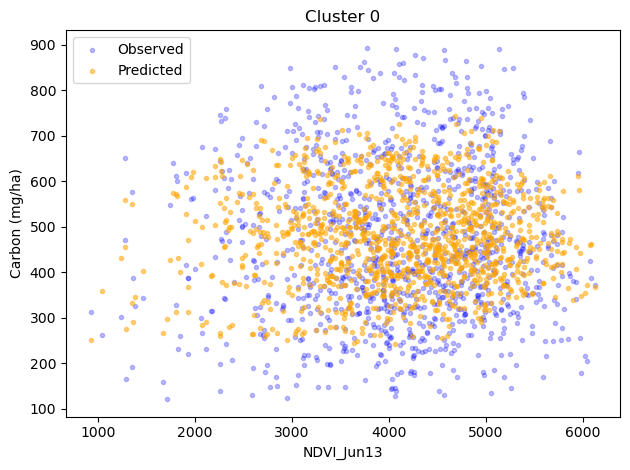

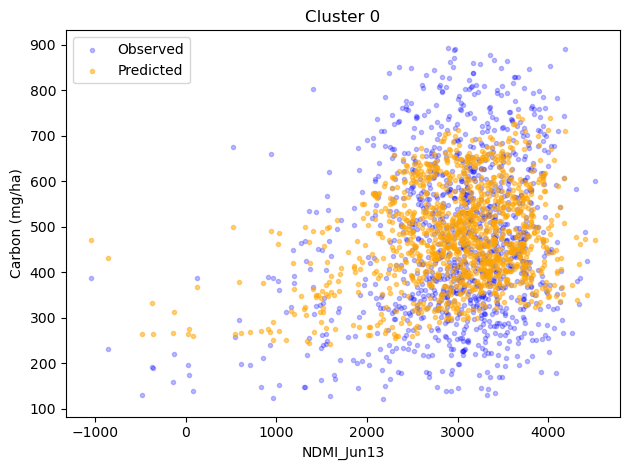

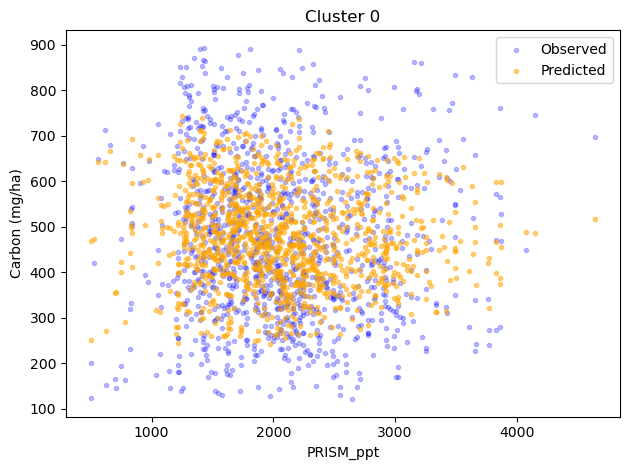

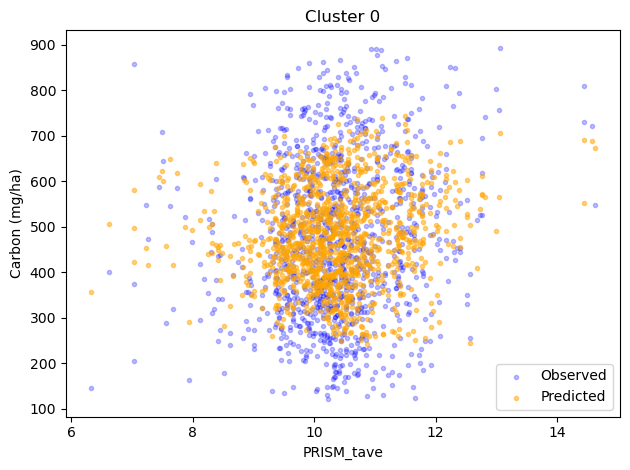

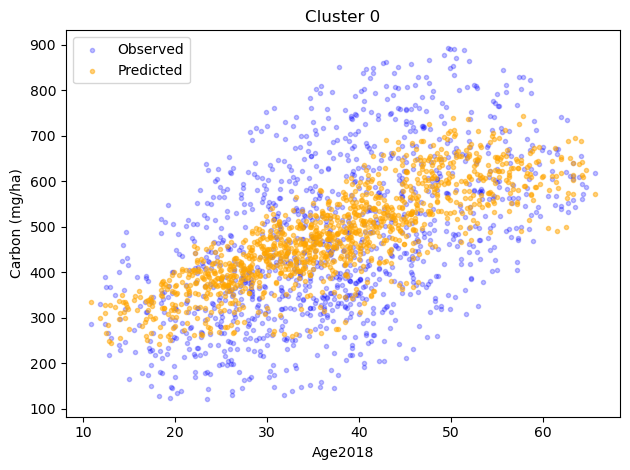

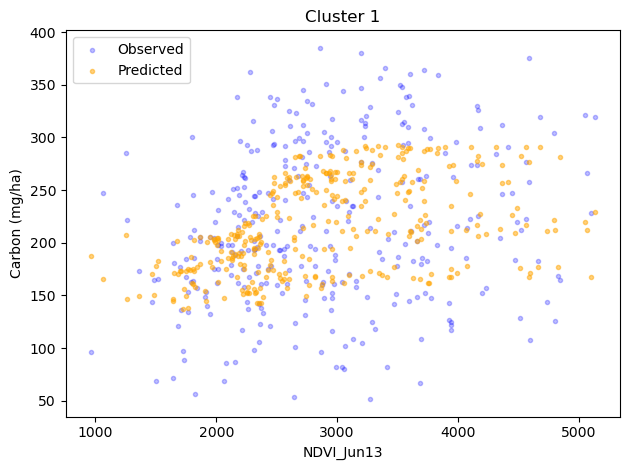

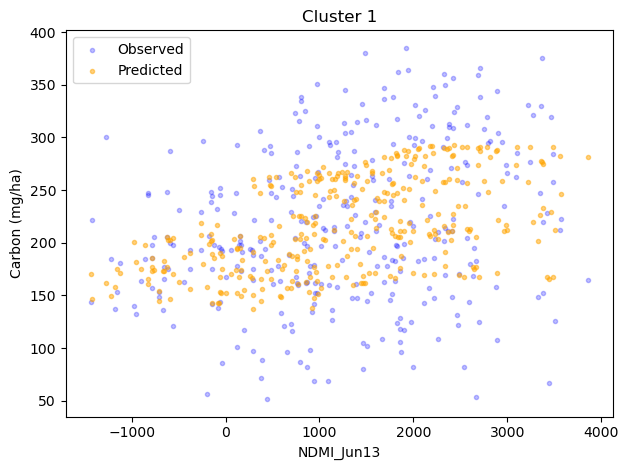

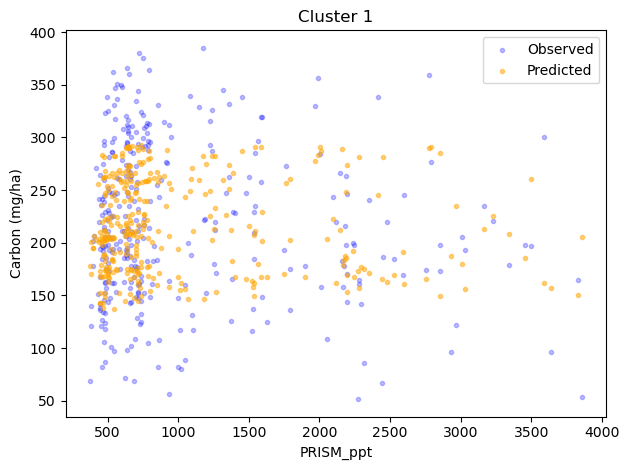

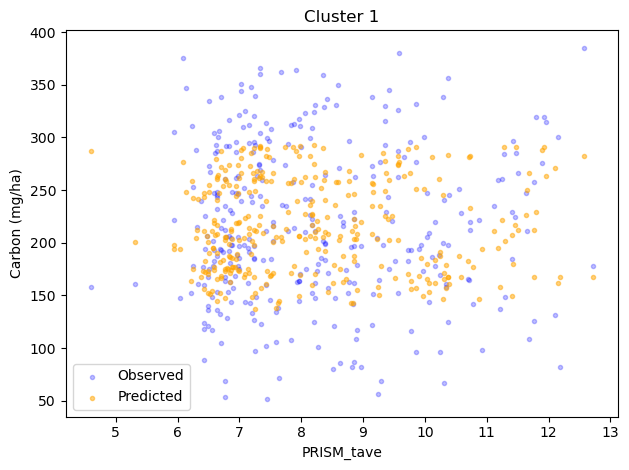

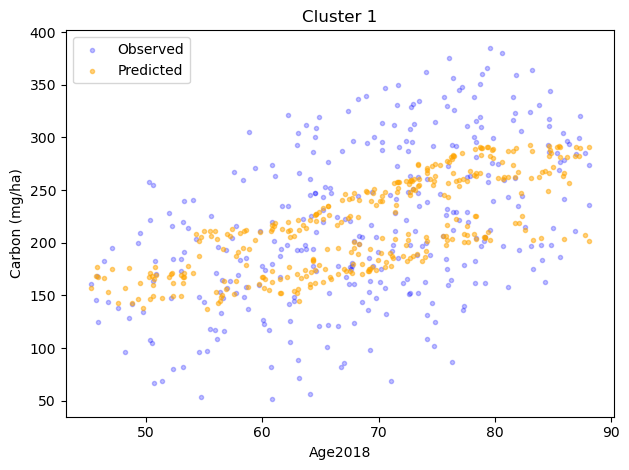

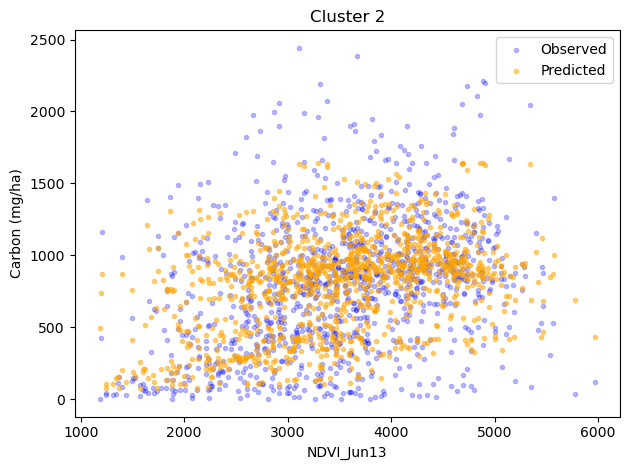

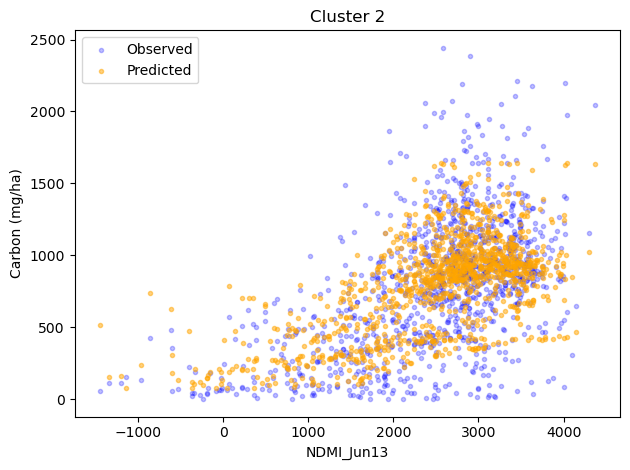

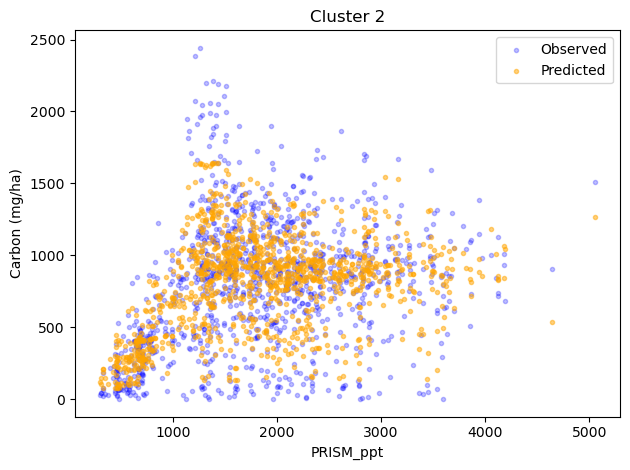

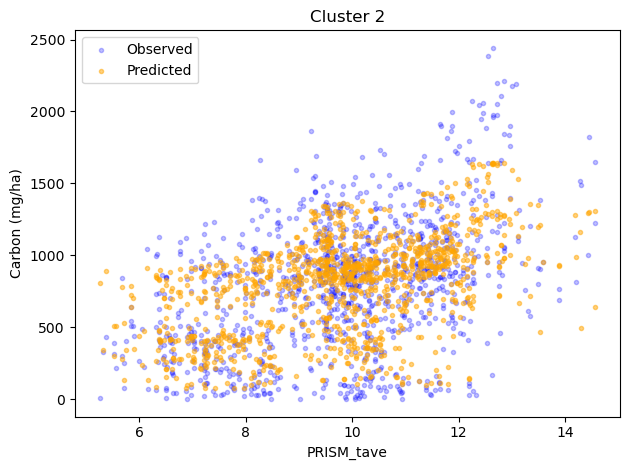

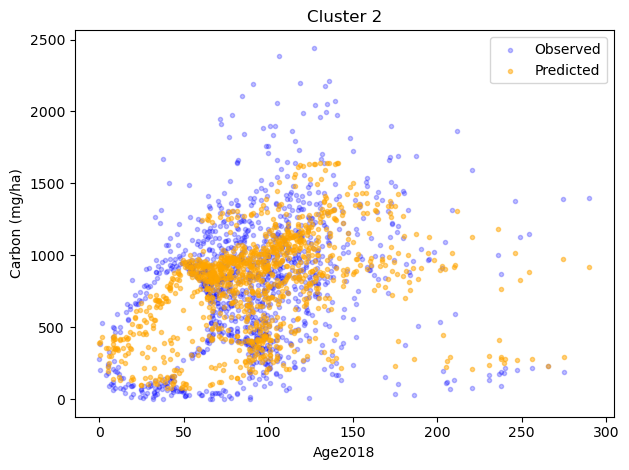

In [119]:
pred_0 = model_0.predict(model_data_0.get_x()[1])

for k, v in enumerate(model_data_0.get_x()[1]):
    plot1 = plt.scatter(model_data_0.get_x()[1][v], model_data_0.get_y()[1], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
    plot2 = plt.scatter(model_data_0.get_x()[1][v], pred_0, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
    plt.ylabel('Carbon (mg/ha)')
    plt.xlabel(v)
    plt.legend(handles=[plot1, plot2], loc='best',)
    plt.title('Cluster 0')
    plt.tight_layout()
    plt.show()

pred_1 = model_1.predict(model_data_1.get_x()[1])

for k, v in enumerate(model_data_1.get_x()[1]):
    plot1 = plt.scatter(model_data_1.get_x()[1][v], model_data_1.get_y()[1], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
    plot2 = plt.scatter(model_data_1.get_x()[1][v], pred_1, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
    plt.ylabel('Carbon (mg/ha)')
    plt.xlabel(v)
    plt.legend(handles=[plot1, plot2], loc='best',)
    plt.title('Cluster 1')
    plt.tight_layout()
    plt.show()

pred_2 = model_2.predict(model_data_2.get_x()[1])

for k, v in enumerate(model_data_2.get_x()[1]):
    plot1 = plt.scatter(model_data_2.get_x()[1][v], model_data_2.get_y()[1], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
    plot2 = plt.scatter(model_data_2.get_x()[1][v], pred_2, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
    plt.ylabel('Carbon (mg/ha)')
    plt.xlabel(v)
    plt.legend(handles=[plot1, plot2], loc='best',)
    plt.title('Cluster 2')
    plt.tight_layout()
    plt.show()

## Visualizing Errors

Cluster 0


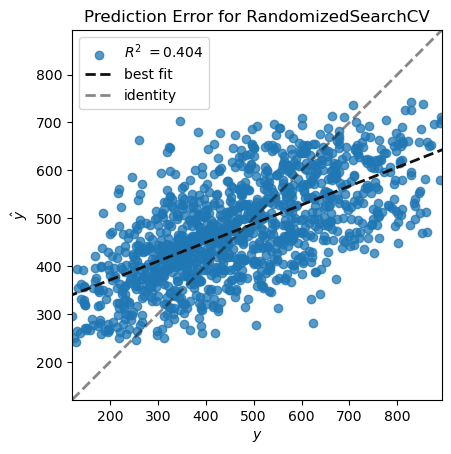

0.4039238242615939
Cluster 1


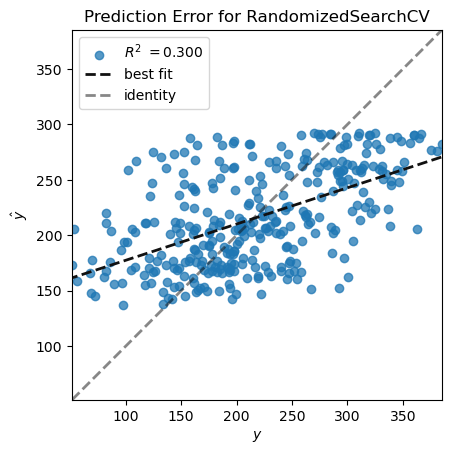

0.30043247954213836
Cluster 2


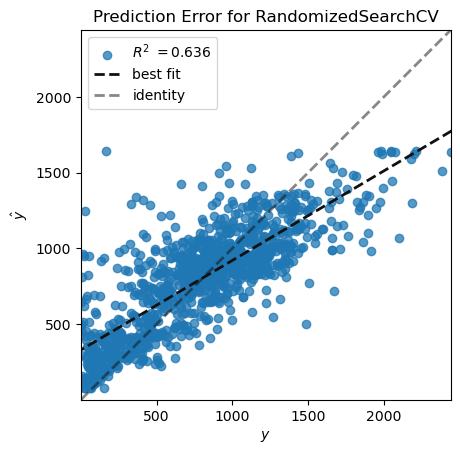

0.6364121408773007


In [120]:
print('Cluster 0')
visualizer_0 = PredictionError(carbon_rf_0)
visualizer_0.score(model_data_0.get_x()[1],  model_data_0.get_y()[1])
visualizer_0.poof()
f_list_0 = [model_data_0.get_x()[0].columns]
print(r2_score(model_data_0.get_y()[1], pred_0))

print('Cluster 1')
visualizer_1 = PredictionError(carbon_rf_1)
visualizer_1.score(model_data_1.get_x()[1],  model_data_1.get_y()[1])
visualizer_1.poof()
f_list_1 = [model_data_1.get_x()[0].columns]
print(r2_score(model_data_1.get_y()[1], pred_1))

print('Cluster 2')
visualizer_2 = PredictionError(carbon_rf_2)
visualizer_2.score(model_data_2.get_x()[1],  model_data_2.get_y()[1])
visualizer_2.poof()
f_list_2 = [model_data_2.get_x()[0].columns]
print(r2_score(model_data_2.get_y()[1], pred_2))

## Displaying Importance Values and Best Estimator Parameters

Cluster 0
Feature Importance:
Age2018       0.573057
NDMI_Jun13    0.196001
NDVI_Jun13    0.107438
PRISM_tave    0.068570
PRISM_ppt     0.054935
dtype: float64 

Age2018


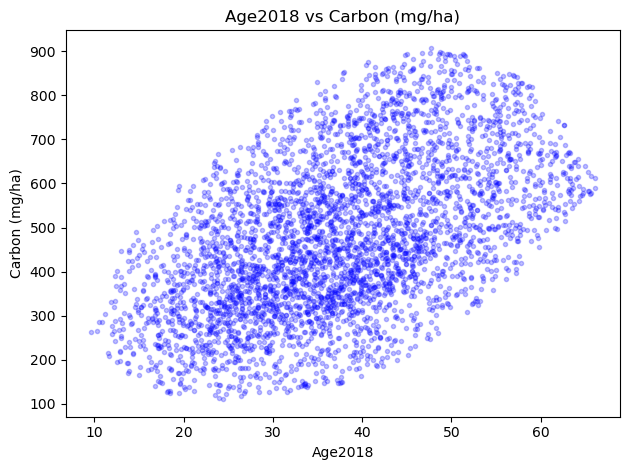

Best Estimator & Parameters:
Score:  0.404
{'scale__n_quantiles': 1837, 'model__n_estimators': 109, 'model__min_samples_split': 45, 'model__min_samples_leaf': 14, 'model__max_features': 624, 'model__max_depth': 1858} 

mean_fit_time                                                              1.805499
std_fit_time                                                               1.654289
mean_score_time                                                            0.013773
std_score_time                                                             0.013673
param_scale__n_quantiles                                                       1837
param_model__n_estimators                                                       109
param_model__min_samples_split                                                   45
param_model__min_samples_leaf                                                    14
param_model__max_features                                                       624
param_model__max_depth   

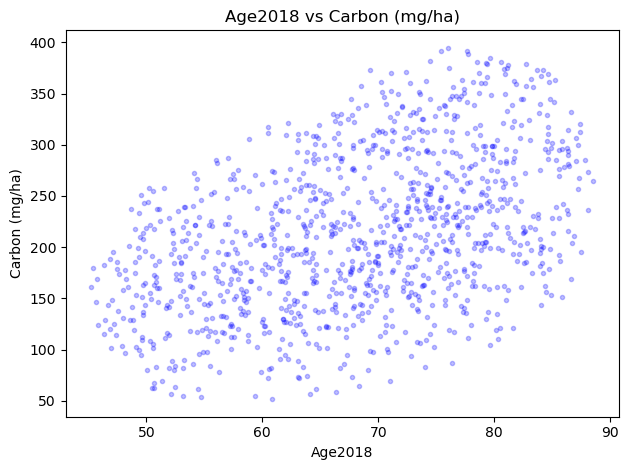

Best Estimator & Parameters:
Score:  0.3
{'scale__n_quantiles': 104, 'model__n_estimators': 578, 'model__min_samples_split': 31, 'model__min_samples_leaf': 35, 'model__max_features': 56, 'model__max_depth': 741} 

mean_fit_time                                                              1.012389
std_fit_time                                                               0.313883
mean_score_time                                                            0.017047
std_score_time                                                             0.004637
param_scale__n_quantiles                                                        104
param_model__n_estimators                                                       578
param_model__min_samples_split                                                   31
param_model__min_samples_leaf                                                    35
param_model__max_features                                                        56
param_model__max_depth        

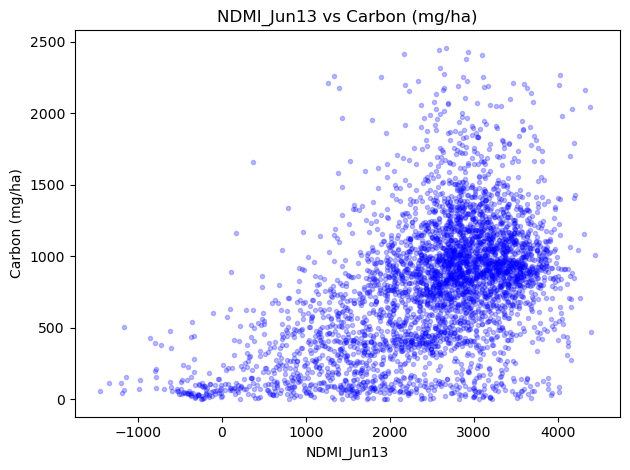

Best Estimator & Parameters:
Score:  0.636
{'scale__n_quantiles': 706, 'model__n_estimators': 549, 'model__min_samples_split': 64, 'model__min_samples_leaf': 38, 'model__max_features': 431, 'model__max_depth': 1595} 

mean_fit_time                                                              3.390555
std_fit_time                                                               0.148167
mean_score_time                                                            0.023587
std_score_time                                                             0.003731
param_scale__n_quantiles                                                        706
param_model__n_estimators                                                       549
param_model__min_samples_split                                                   64
param_model__min_samples_leaf                                                    38
param_model__max_features                                                       431
param_model__max_depth    

In [121]:
print('Cluster 0')
importance_0 = pd.Series(
    carbon_rf_0.best_estimator_._final_estimator.feature_importances_,
    carbon_rf_0.best_estimator_.feature_names_in_,
).sort_values(ascending=False)
print('Feature Importance:')
print(importance_0, '\n')

# Displaying all the Data
print(importance_0.index[0])
plot1 = plt.scatter(USFS_forest_0[importance_0.index[0]], USFS_forest_0['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel(importance_0.index[0])
plt.title(importance_0.index[0]+' vs Carbon (mg/ha)')
# plt.legend(handles=[plot1], loc='best',)
plt.tight_layout()
plt.show()

print('Best Estimator & Parameters:')
print('Score: ', round(r2_score(model_data_0.get_y()[1], pred_0), 3))
print(carbon_rf_0.best_params_, '\n')
print(results_0.loc[carbon_rf_0.best_index_], '\n')

print('Cluster 1')
importance_1 = pd.Series(
    carbon_rf_1.best_estimator_._final_estimator.feature_importances_,
    carbon_rf_1.best_estimator_.feature_names_in_,
).sort_values(ascending=False)
print('Feature Importance:')
print(importance_1, '\n')

# Displaying all the Data
print(importance_1.index[0])
plot1 = plt.scatter(USFS_forest_1[importance_1.index[0]], USFS_forest_1['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel(importance_1.index[0])
plt.title(importance_1.index[0]+' vs Carbon (mg/ha)')
# plt.legend(handles=[plot1], loc='best',)
plt.tight_layout()
plt.show()

print('Best Estimator & Parameters:')
print('Score: ', round(r2_score(model_data_1.get_y()[1], pred_1), 3))
print(carbon_rf_1.best_params_, '\n')
print(results_1.loc[carbon_rf_1.best_index_], '\n')

print('Cluster 2')
importance_2 = pd.Series(
    carbon_rf_2.best_estimator_._final_estimator.feature_importances_,
    carbon_rf_2.best_estimator_.feature_names_in_,
).sort_values(ascending=False)
print('Feature Importance:')
print(importance_2, '\n')

# Displaying all the Data
print(importance_2.index[0])
plot1 = plt.scatter(USFS_forest_2[importance_2.index[0]], USFS_forest_2['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel(importance_2.index[0])
plt.title(importance_2.index[0]+' vs Carbon (mg/ha)')
# plt.legend(handles=[plot1], loc='best',)
plt.tight_layout()
plt.show()

print('Best Estimator & Parameters:')
print('Score: ', round(r2_score(model_data_2.get_y()[1], pred_2), 3))
print(carbon_rf_2.best_params_, '\n')
print(results_2.loc[carbon_rf_2.best_index_], '\n')


## Saving the model (in binary) to a file 

In [122]:
# with open('./savedModels/'+'model_carbon_'+str(round(r2_score(model_data_2.get_y()[1], pred), 4))+'.pkl', 'wb') as savefile:
#     pickle.dump(carbon_rf, savefile)
# print('Save completed!')